1. Import Module

In [19]:
import random
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

In [20]:
# import google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


2. Tentukan Lokasi Dataset

In [21]:
train_dir = '/content/drive/MyDrive/DatasetDaun/train'
val_dir = '/content/drive/MyDrive/DatasetDaun/validation'

3. Augmentasi gambar

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

4. Load dataset ke dalam “generator”

In [23]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 78 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


5. Build Model MobileNetV2

In [24]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))


for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

6. Train Model

In [41]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[early_stop]
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.7404 - loss: 0.5262 - val_accuracy: 0.6533 - val_loss: 0.7063
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.7756 - loss: 0.5424 - val_accuracy: 0.6533 - val_loss: 0.7015
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.8062 - loss: 0.5050 - val_accuracy: 0.6533 - val_loss: 0.6970
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 5s/step - accuracy: 0.7216 - loss: 0.5562 - val_accuracy: 0.6533 - val_loss: 0.6928


7. Evaluate Model

In [42]:
val_loss, val_acc = mobilenet_model.evaluate(val_generator)
print(f"\nAkurasi Validasi MobileNetV2: {val_acc*100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 896ms/step - accuracy: 0.6274 - loss: 0.7289

Akurasi Validasi MobileNetV2: 65.33%


8.  Visualization Of Train Performance

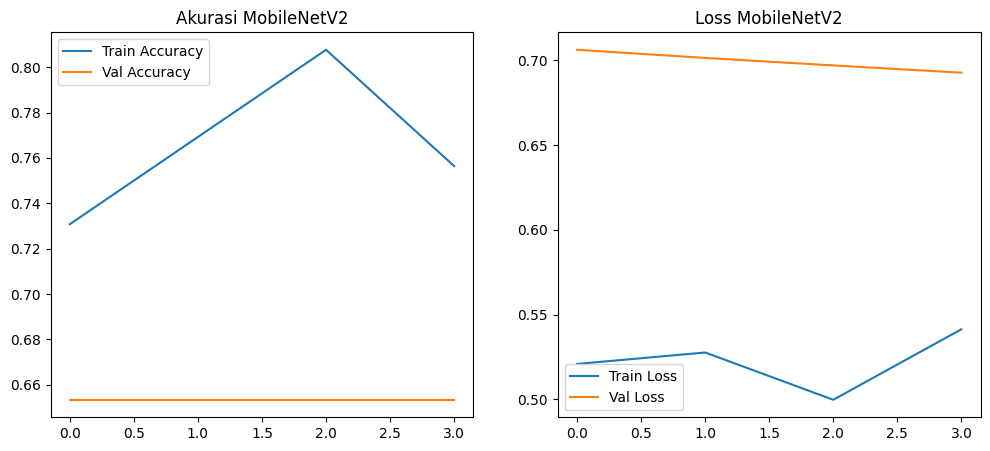

In [43]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi MobileNetV2')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Val Loss')
plt.title('Loss MobileNetV2')
plt.legend()

plt.show()

9. Result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


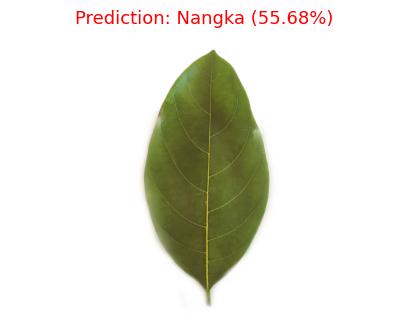

Gambar: /content/drive/MyDrive/DatasetDaun/train/Daun Nangka/008.jpg
Prediksi Model: Nangka (55.68%)


In [44]:
random_class = random.choice(os.listdir(train_dir))
class_path = os.path.join(train_dir, random_class)

# Ambil 1 gambar random dari kelas tersebut
random_image = random.choice(os.listdir(class_path))
img_path = os.path.join(class_path, random_image)

# Load dan preprocess gambar
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Prediksi
pred = mobilenet_model.predict(img_array)
predicted_class = list(train_generator.class_indices.keys())[np.argmax(pred)]
confidence = np.max(pred) * 100

# Tampilkan hasil
plt.figure(figsize=(5,5))
plt.imshow(image.load_img(img_path))
plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)", color='red', fontsize=13)
plt.axis("off")
plt.show()

print(f"Gambar: {img_path}")
print(f"Prediksi Model: {predicted_class} ({confidence:.2f}%)")